In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import constants as aconst
from astropy import units as au
from lmfit import minimize, Parameters
from copy import deepcopy as dc
from tqdm import tqdm
from scipy.stats import norm
from scipy.interpolate import InterpolatedUnivariateSpline as ius

import utilities as utils
import utilities_fit as utils_fit
import spec as gspec
import spec_manipulation as spec_man
import mpfit as mpf
import liske as lsk

%matplotlib widget

In [3]:
%load_ext autoreload
%autoreload 2

#### The following will be used to test if my implementation works the way it should
or, sadly, to discover that the original paper had issues :P

In [4]:
# general variable, should stay here and never change

# How many times repeat mc simulations?
mc_n_rep = 5000

# histogram bins
nbins = 30

# x points for plots
x_plot = np.arange(0.5, 7., 0.01)

# number of pixel for splining
n_smooth_pix_1 = 2
n_smooth_pix_2 = 2
y_corr_err = 2 / (2 * np.sqrt(2 * np.log(2))) # this is correct for R = 100000, and a dispersion of 1.5 km/s per pixel. If different, you recompute this value!

# Note that from here on we assume a baseline resolution of 1e5, based on the dispersion they mention in the paper
# It should never change, but what do I know...

In [5]:
p_sp_1 = {
    'snr' : 100,
    'R' : 1e5,                     # resolution should be roughly twice the dispersion, otherwise boh!
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms,
    'noise_amp' : 0.01             # If I want the spectrum to have SNR equal to 100, this is the noise amplitude I need for the continuum
                                   # should not need to set this, but it's safer to keep things explicit, so here it stays
}

p_sp_2 = {
    'snr' : 100,
    'R' : 1e5,
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms,
    'noise_amp' : 0.01
}

s1, s2 = spec_man.gen_spec_pair(p_sp_1 = p_sp_1, p_sp_2 = p_sp_2)

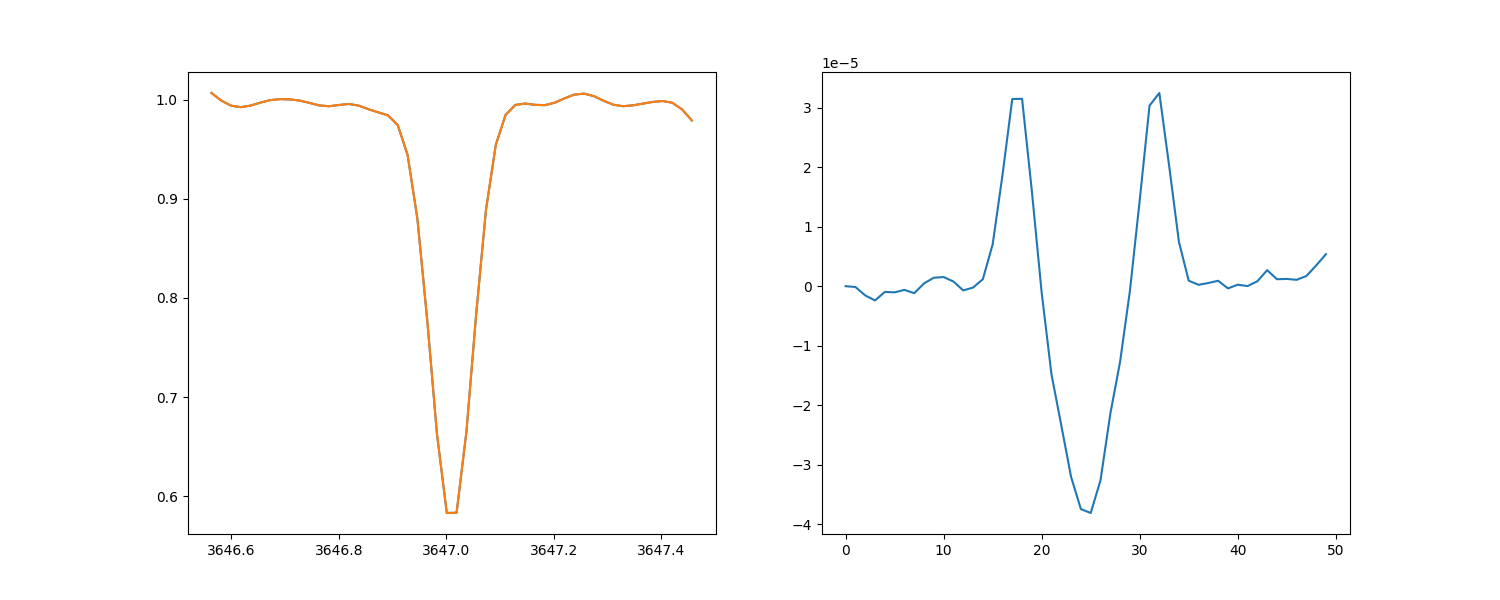

In [5]:
# 1 - check that my spline and smooth routines match MM and TE
# this is the same exact code from barak, just update to Py3
import barak as bk

t_p_sp_1 = {
    'z_em' : 2.,
    'snr' : 100,
    'R' : 1e5,                     # resolution should be roughly twice the dispersion, otherwise boh!
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms,
    'noise_amp' : 0.01             # If I want the spectrum to have SNR equal to 100, this is the noise amplitude I need for the continuum
                                   # should not need to set this, but it's safer to keep things explicit, so here it stays
}

t_s1 = gspec.mock_spec(**t_p_sp_1)
t_s1.generate()

# check that the conversion utility from kms to AA and viceversa is consistent -> OK!
t_s1.x_w = t_s1.convert_x(au.AA)
t_s1.convert_x(utils.kms)
t_wave_scale = bk.make_constant_dv_wa_scale(t_s1.x_w[0], t_s1.x_w[-1], t_s1.dispersion.value)

# smooth using Barak
barak_convolution_1 = bk.convolve_constant_dv(t_s1.x_w.value, t_s1.y.value, vfwhm = 4 * t_s1.dispersion.value)
# use the function under the hood, so that if there are differences we can trace back to the wrapper
barak_convolution_2 = bk.convolve_psf(t_s1.y.value, fwhm = 4, edge = 'invert')
# smooth using my implementation
t_s1.smooth(4)

fig, ax = plt.subplots(1, 2, figsize = (15, 6))
ax[0].plot(t_s1.x_w, barak_convolution_1)
ax[0].plot(t_s1.x_w, t_s1.y_smooth)

ax[1].plot(barak_convolution_1 - t_s1.y_smooth)

# takeaway: the thing mostly works, and using convolve psf I get nearly the same result
# this is not true for convolve_constant_dv, where I suspect that the back and forth interpolation is causing some issues

(0.0, 1.1)

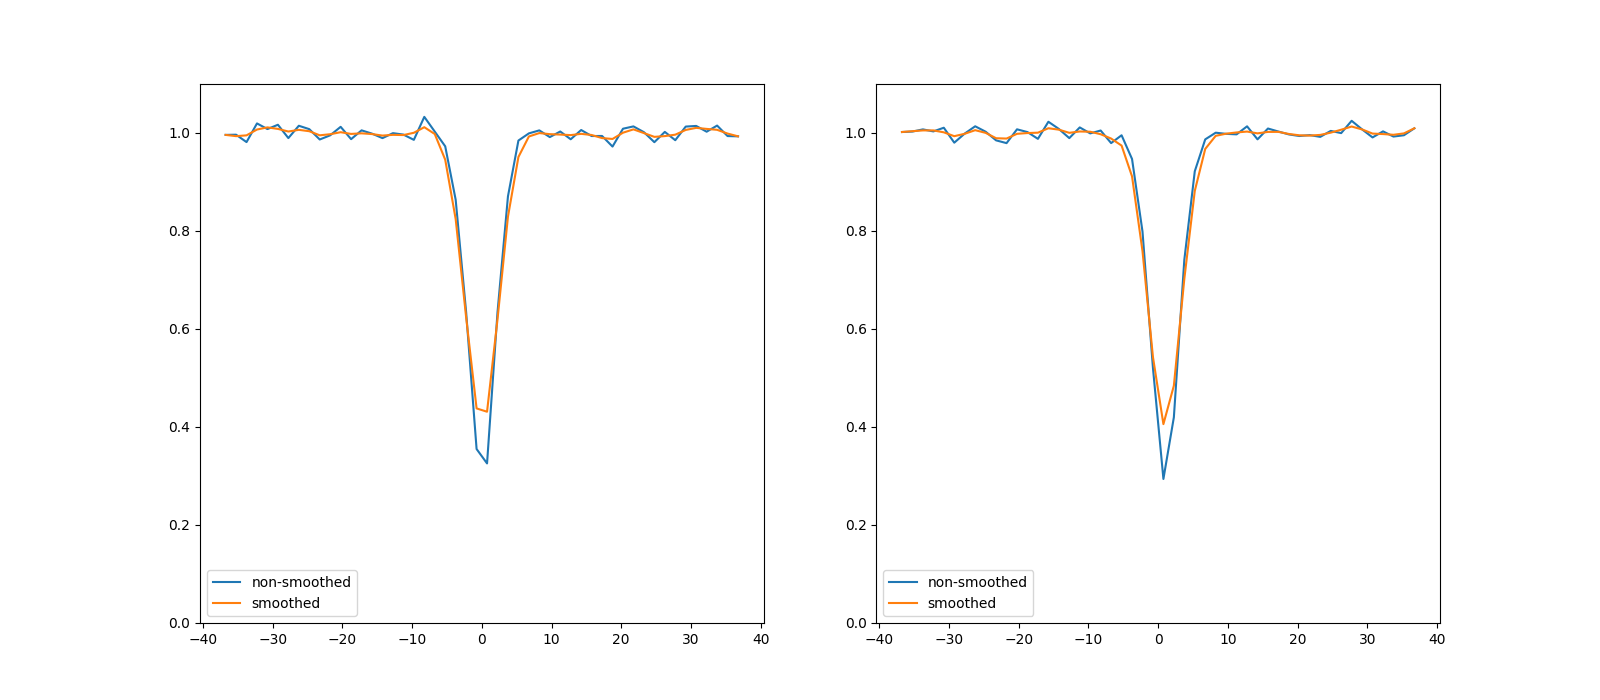

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (16, 7))
ax[0].plot(s1.x, s1.y, label = 'non-smoothed')
ax[1].plot(s2.x, s2.y, label = 'non-smoothed')

ax[0].plot(s1.x, s1.y_smooth, label = 'smoothed')
ax[1].plot(s2.x, s2.y_smooth, label = 'smoothed')

ax[0].legend()
ax[1].legend()

ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 1.1)

In [7]:
# sick and tired of this, we import the MM code and see if things check out. If not, we can try to figure out why
def deviates_nopen(param, fjac=None, x=None, y=None, err=None, MVel=None,
                   MyCut=None, MerrCut=None, kFlux=None, kErrorS=None):
    """
    Deviates RETURNS the CHI statistic. MPFIT calls deviates and minimises
    CHI by altering parameters.
    """

    status = 0

    Merror = np.array(MerrCut)

    # all of the changes to the model that can be used (x, y, error)
    shift = MVel+param[0]
    scale = (param[1]+param[2]*MVel)

    # what to shift in order to min chi^2
    yfinal = kFlux(shift)
    Serror = kErrorS(shift)
    yfinal = yfinal*scale
    Serror = Serror*scale

    # chi for two noisy spectra
    chi = ((yfinal-MyCut)/np.sqrt((Merror*Merror)+(Serror*Serror)))

    return (status, chi)

def set_mpfit_params():
        parinfo = [{} for i in range(3)]
        parinfo[0]['step'] = 0.005  # in km/s
        parinfo[1]['step'] = 1.E-5
        parinfo[2]['step'] = 1.E-6
        parinfo[0]['mpside'] = 2
        parinfo[1]['mpside'] = 2
        parinfo[2]['mpside'] = 2

        shiftguess = 0.  # in km/s
        scaleguess = 1.001
        tiltguess = 0.E-5
        quiet = 1
        p0 = [shiftguess, scaleguess, tiltguess]
        return parinfo, p0, quiet


# perform chi2 minimization for spectra using mpfit
#  I do this just to check if things are wrong on the LMFit side, or there is something else
#  I a missing in the scripts

kFlux = ius(s2.x.value, s2.y_smooth.value) # SyCut)
kErrorS = ius(s2.x.value, s2.dy_smooth.value) # SerrCut)

fa = {'x': s2.x.value, 'y': s2.y_smooth.value, 'err': s2.dy_smooth.value, 'MVel': s1.x.value, 'MyCut': s1.y_smooth.value,
        'MerrCut': s1.dy_smooth.value, 'kFlux': kFlux, 'kErrorS': kErrorS}

parinfo = [{} for i in range(3)]

# size of stepping parameter between iterations
parinfo[0]['step'] = 0.005  # in km/s
parinfo[1]['step'] = 1.E-5
parinfo[2]['step'] = 1.E-6

# derivative method:
# -1 is left hand difference derrivitive
# 1 is right hand derrivative
# 2 is double sided.
parinfo[0]['mpside'] = 2
parinfo[1]['mpside'] = 2
parinfo[2]['mpside'] = 2

shiftguess = 0.  # in km/s
scaleguess = 1.001
tiltguess = 0.E-5
quiet = 1

p0 = [shiftguess, scaleguess, tiltguess]
m = mpf.mpfit(deviates_nopen, p0, functkw = fa, parinfo = parinfo, quiet = quiet)

pchi = [m.params[0], m.params[1], m.params[2]]
print(pchi)

# calculate the scaled error
chi2 = m.fnorm
dof = len(s1.x.value)-len(m.params) - 1

chi2_nu = chi2/dof

chi2_nu
m.perror;

[0.947326484244453, 0.9995719624532114, -6.61504454538483e-05]


In [8]:
# loop with mpfit, no correction or anything.
# this should give us an idea of how things correlate between the two fitting routines
#   and if we have to make any kind of changes
mpf_mc_val = []
mpf_mc_err = []
mpf_mc_xsq = []

for i in tqdm(range(mc_n_rep)):
    mpf_mc_s1, mpf_mc_s2 = spec_man.gen_spec_pair(p_sp_1, p_sp_2, shift = 0.3 * utils.kms, n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2)

    mpf_mc_kFlux = ius(mpf_mc_s2.x.value, mpf_mc_s2.y_smooth.value)
    mpf_mc_kErrorS = ius(mpf_mc_s2.x.value, mpf_mc_s2.dy.value)

    mpf_mc_fa = {'x': mpf_mc_s2.x.value, 'y': mpf_mc_s2.y_smooth.value, 'err': mpf_mc_s2.dy.value, 'MVel': mpf_mc_s1.x.value, 'MyCut': mpf_mc_s1.y_smooth.value,
        'MerrCut': mpf_mc_s1.dy.value, 'kFlux': mpf_mc_kFlux, 'kErrorS': mpf_mc_kErrorS}

    mc_parinfo, mc_p0, mc_quiet = set_mpfit_params()
    mc_mpf_out = mpf.mpfit(deviates_nopen, mc_p0, functkw = mpf_mc_fa, parinfo = mc_parinfo, quiet = mc_quiet)

    # calculate the scaled error
    mc_mpf_chi2 = mc_mpf_out.fnorm
    mc_mpf_dof = len(mpf_mc_s1.x.value)-len(mc_mpf_out.params)

    mc_mpf_chi2_nu = mc_mpf_chi2/mc_mpf_dof

    mpf_mc_val.append(mc_mpf_out.params[0])
    mpf_mc_err.append(mc_mpf_out.perror[0] * np.sqrt(mc_mpf_chi2_nu))
    mpf_mc_xsq.append(mc_mpf_chi2_nu)

100%|██████████| 5000/5000 [00:37<00:00, 133.69it/s]


Average chi square for this round: 0.327


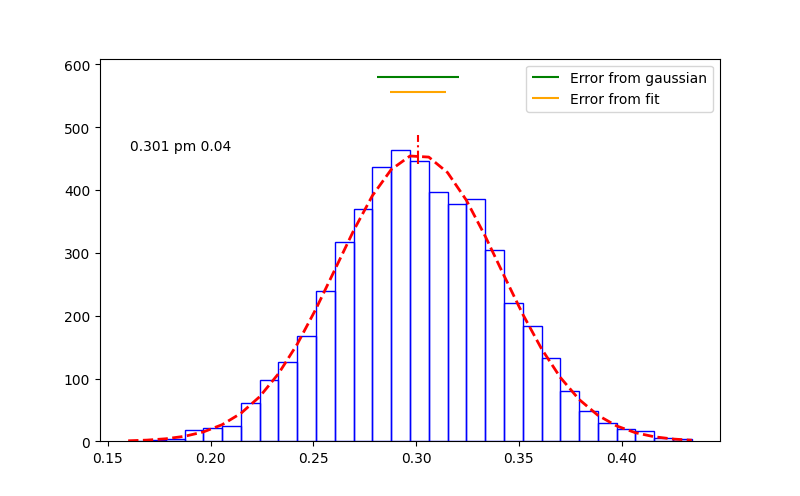

In [9]:
utils.plot_simulation_results(mpf_mc_val, mpf_mc_err, mpf_mc_xsq);

In [10]:
# Now I want to test using some Montecarlo. Following the paper, I repeat 5000 times the same procedure, and see what happens

mc_params = Parameters()
mc_params.add('ampl',  value=1)
mc_params.add('shift', value=0.8)
mc_params.add('tilt',  value=0)

# collect all estimates of value and error
mc_val = []
mc_err = []
mc_xsq = []

for i in tqdm(range(mc_n_rep)):
    val, err, chi = utils_fit.fit_for_shift(p_sp_1, p_sp_2, shift=0.3 * utils.kms, n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2, correct_for_smooth=False, correct_for_err = False)
    mc_val.append(val)
    mc_err.append(err)
    mc_xsq.append(chi)


100%|██████████| 5000/5000 [00:32<00:00, 155.72it/s]


Average chi square for this round: 0.325


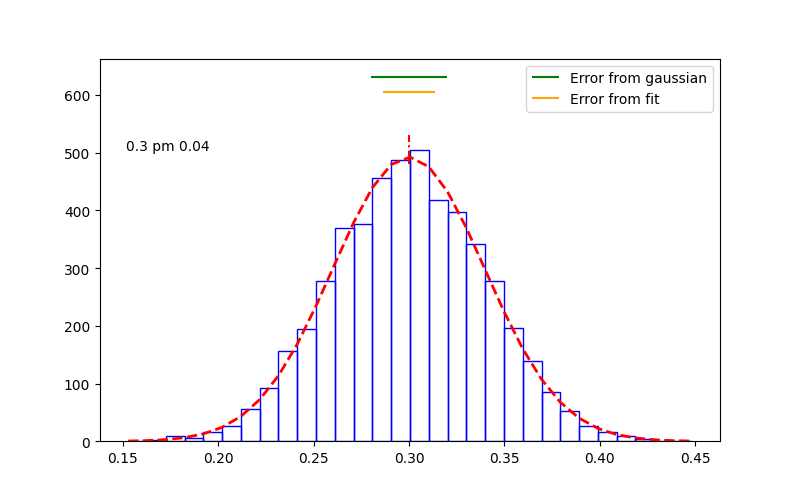

In [11]:
utils.plot_simulation_results(mc_val, mc_err, mc_xsq);

In [12]:
# also checks that the second spectrum has a shift consistent with zero -> it does!
# also with both if shift = 0, even if tails are broader

tt_mc_params = Parameters()
tt_mc_params.add('ampl',  value = 1)
tt_mc_params.add('shift', value = 0.8)
tt_mc_params.add('tilt',  value = 0)

# collect all estimates of value and error
tt_mc_val = []
tt_mc_err = []
tt_mc_xsq = []

for i in tqdm(range(mc_n_rep)):
    val, err, chi = utils_fit.fit_for_shift(p_sp_1, p_sp_2, shift=0.0 * utils.kms,
                                            n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2, correct_for_smooth=False, correct_for_err = False)
    tt_mc_val.append(val)
    tt_mc_err.append(err)
    tt_mc_xsq.append(chi)

100%|██████████| 5000/5000 [00:30<00:00, 163.97it/s]


Average chi square for this round: 0.325


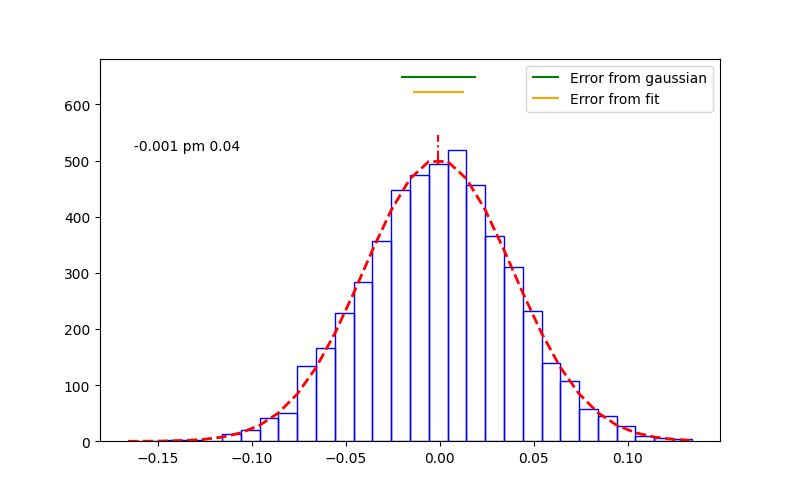

In [13]:
utils.plot_simulation_results(tt_mc_val, tt_mc_err, tt_mc_xsq);

In [14]:
# cell updated after after MM email, and with fixed convolution window - now we properly account for pixel dispersion

# let's try a different approach and see if I can re-construct everything from scrath
# define a function that allow to repeat the loop ad libitum

In [15]:
%%script echo Skipped

p_sp_1 = {
    'snr' : 100,
    'R' : 1e5,
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 100,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms
}

p_sp_2 = {
    'snr' : 100,
    'R' : 1e5,
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 100,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms
}

res_all_chi2_red = {}
# change dispersion
for i in np.arange(12, 32, 3)/10:
    res_all_chi2_red[i] = utils_fit.loop_change_dispersion(p_sp_1, p_sp_2, utils_fit.fit_many_times, 0.5 * utils.kms, 8.5 * utils.kms, 0.5 * utils.kms, i * utils.kms, i * utils.kms, rep = 1000, correct_for_err=False, correct_for_smooth=False)

Skipped


In [16]:
%%script echo Skipped
# save data
with open("./data/all_chi2_red.npy", 'wb') as f:
    np.save(f, {"smooth_1" : n_smooth_pix_1, "smooth_2" : n_smooth_pix_2})
    np.save(f, res_all_chi2_red)

Skipped


In [17]:
# results from the cell above, but the data points from mm seem mostly fine
with open("./data/all_chi2_red.npy", 'rb') as f:
    _ = np.load(f, allow_pickle = True)
    res_all_chi2_red = np.load(f, allow_pickle = True).item()

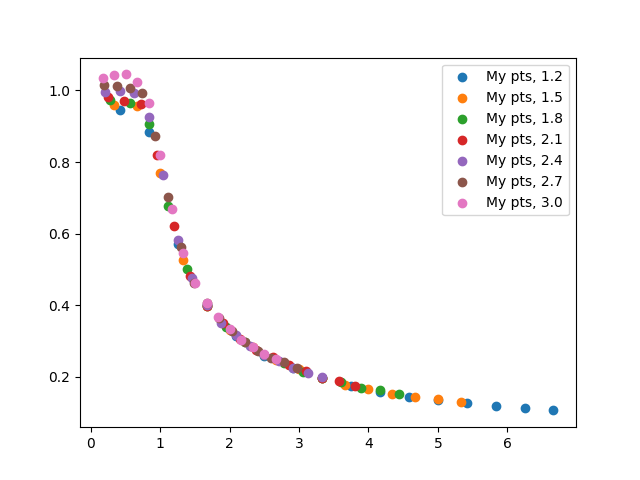

In [18]:
# There is a mistake in MM paper, that x was supposed to be log(x) - see email
# also, keep in mind that for the plotting array: 0 -> shift, 1 -> err, 2 -> xsq

pts_fig_3 = np.array([
[0.324, 0.753],
[0.660, 0.590],
[0.995, 0.471],
[1.325, 0.387],
[1.655, 0.324],
[2.001, 0.284],
[2.315, 0.244],
[2.661, 0.217],
[3.002, 0.191],
[3.327, 0.173],
[3.998, 0.148],
[4.663, 0.120],
[5.339, 0.108]])

# plot both together
fig, ax = plt.subplots(1, 1)
for key in res_all_chi2_red.keys():
    ax.scatter(res_all_chi2_red[key][1], np.mean(np.array(res_all_chi2_red[key][0])[:, 2], axis = 1), label = "My pts, " + str(key))

ax.legend()

In [19]:
# find again the parameters for fig 3

params_fig_3 = Parameters()
params_fig_3.add('a', value = 0)
params_fig_3.add('b', value = 0)
params_fig_3.add('c', value = 0)
params_fig_3.add('d', value = 0, vary = False)

xval = pts_fig_3[:, 0]
yval = pts_fig_3[:, 1]

def fix_x2_residual(pars, x, data = None, err = None):
    vals = pars.valuesdict()
    a = vals['a']
    b = vals['b']
    c = vals['c']
    d = vals['d']

    model = d + np.exp(a * np.log(x)**2 + b * np.log(x) + c)

    return (model - data)/err

# Errors are kinda random, to give more weight to the extreme points
# Could improve on this
fix_x2_out     = minimize(fix_x2_residual, params_fig_3, args=(xval,), kws={'data': yval, 'err' : np.ones(yval.shape) * 0.1})
fix_x2_outvals = fix_x2_out.params.valuesdict()
fix_x2_outvals

{'a': -0.17093145629964898,
 'b': -0.6161632956085996,
 'c': -0.7593970179087314,
 'd': 0}

Chi2 for this fit: 0.13


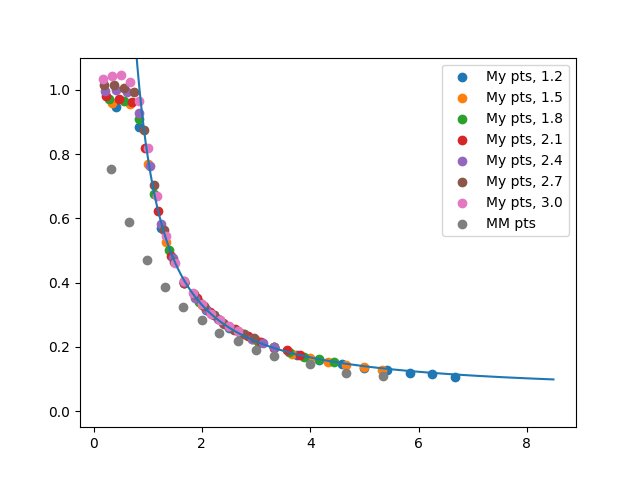

In [20]:
# fit my datapoints for figure 3, not sure why they are different
fig, ax = plt.subplots(1, 1)

# we try to fit all points at the same time - TODO: find out who is making a stupid mistake
params_fig_3 = Parameters()
params_fig_3.add('a', value = 0)
params_fig_3.add('b', value = 0)
params_fig_3.add('c', value = 0)
params_fig_3.add('d', value = 0)


def residual_fix_chi2_red(pars, data = None, plot = False, p_x = np.arange(0.5, 8.5, 0.01)):
    # data in this case is a dictionary that contains all the data, loaded from previous cell
    # computes the model wrt the data
    def compute_model(pars, x):
        vals = pars.valuesdict()
        a = vals['a']
        b = vals['b']
        c = vals['c']
        d = vals['d']
        return d + np.exp(a * np.log(x)**2 + b * np.log(x) + c)

    if plot:
        xval = p_x
        out = compute_model(pars, xval)
    else:
        out = np.array([])
        for key in data.keys():
            xval = data[key][1]
            yval = np.mean(np.array(data[key][0])[:, 2], axis = 1)
            dyval = np.ones(yval.shape) * 0.021

            # cut the first part of the data (they flat, good luck with fitting those with anything)
            #  this depends on the convoluting window, ergo we need to a) find a smart way to perform this automagically or,
            #  b) take the easy route, make a dictionary, and call it a day
            # Guess what we do!
            num_pts_2_exclude = {1.2 : 2, 1.5 : 2, 1.8 : 3, 2.1 : 4, 2.4 : 4, 2.7 : 4, 3.0 : 5}

            xval  =  xval[num_pts_2_exclude[key]:]
            yval  =  yval[num_pts_2_exclude[key]:]
            dyval = dyval[num_pts_2_exclude[key]:]

            out = np.concatenate((out, (compute_model(pars, xval) - yval)/dyval))

    return out

# Could improve on this
fix_x2_out     = minimize(residual_fix_chi2_red, params_fig_3, kws={'data' : res_all_chi2_red, 'plot' : False})
fix_x2_outvals = fix_x2_out.params.valuesdict()
print("Chi2 for this fit: {:.2f}".format(fix_x2_out.redchi))

# ---------------------------------------------- #
# -------------- plot the results -------------- #
# ---------------------------------------------- #

# get the model line
p_x = np.arange(0.5, 8.5, 0.01)
p_model_lines = residual_fix_chi2_red(fix_x2_out.params, data = res_all_chi2_red, plot = True, p_x = p_x)

# get the x points of the lines
ax.plot(p_x, p_model_lines)

# plot both together
for key in res_all_chi2_red.keys():
    ax.scatter(res_all_chi2_red[key][1], np.mean(np.array(res_all_chi2_red[key][0])[:, 2], axis = 1), label = "My pts, " + str(key))

# uncomment to show MM values or line fit
# ax.plot(x_plot, np.exp(-0.16 * np.log(x_plot)**2 - 0.62 * np.log(x_plot) - 0.76), label = "MM params")
ax.scatter(pts_fig_3[:, 0], pts_fig_3[:, 1], label = "MM pts")

ax.set_ylim(-0.05, 1.1)
ax.legend()

In [21]:
# see if the correction is ok
mc_fix_x2_params = Parameters()
mc_fix_x2_params.add('ampl',  value = 1)
mc_fix_x2_params.add('shift', value = 0.8)
mc_fix_x2_params.add('tilt',  value = 0)

# collect all estimates of value and error
mc_fix_x2_val = []
mc_fix_x2_err = []
mc_fix_x2_xsq = []

for i in tqdm(range(mc_n_rep)):
    val, err, chi = utils_fit.fit_for_shift(p_sp_1, p_sp_2, shift=0.3 * utils.kms,
                                            n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2, correct_for_smooth=True, correct_for_err = False, corrfunc= lambda x: utils_fit.chi2_corr_func(x, params = fix_x2_outvals))
    mc_fix_x2_val.append(val)
    mc_fix_x2_err.append(err)
    mc_fix_x2_xsq.append(chi)

100%|██████████| 5000/5000 [00:32<00:00, 152.60it/s]


Average chi square for this round: 0.982


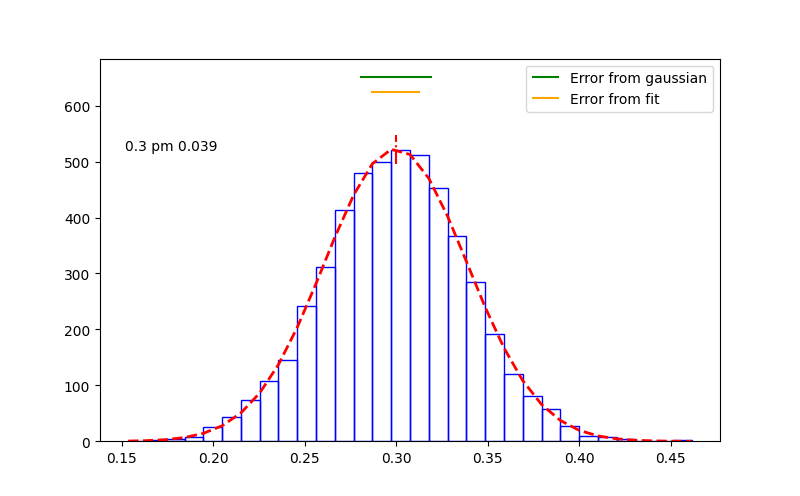

In [22]:
utils.plot_simulation_results(mc_fix_x2_val, mc_fix_x2_err, mc_fix_x2_xsq);

In [23]:
# Now need to also correct for the error

# these are MM values
#  xi_sigma_MM = np.exp(-0.05 * n_pix_fwhm_smooth**2 - 0.17 * n_pix_fwhm_smooth - 0.28)
#  xi_fwhm_MM  = -0.15 * y_corr_err + 1.22

# Numbers from the paper look kinda off, even if I make the change x -> ln(x). I should really test things out to make sure the relation is the same in my implementation as well
#  for now I am keeping the same formula, but it something to check for sure.
# In any case, we keep the current functional relation, but refit the parameters

In [24]:
# we fit for the resolution, and hope for the best
# still missing a np.log in the formula, manually included
import csv

def readdata(path):
    out = []
    with open(path, 'r') as csvfile:
        tt = csv.reader(csvfile, skipinitialspace = True)
        for t in tt:
            out.append(([float(i) for i in t]))
    return np.array(out)
            
smm_fig_4_blue  = readdata("./data_MMMethod_refit_params/ShiftMM_Blue_2.csv")
smm_fig_4_green = readdata("./data_MMMethod_refit_params/ShiftMM_Green_2.csv")
smm_fig_4_red   = readdata("./data_MMMethod_refit_params/ShiftMM_Red_2.csv")

params_fig_4 = Parameters()
params_fig_4.add('a', value = -0.05, vary = False)
params_fig_4.add('b', value = -0.17, vary = False)
params_fig_4.add('c', value = -0.28, vary = False)
params_fig_4.add('d_1', value = -0.15, vary = False)
params_fig_4.add('R', value = 1e5)
params_fig_4.add('d_3', value = 1.22, vary = False)

# removed d3, fixed by the resolution
def residual_fit_4_res(pars, data_1 = None, data_2 = None, data_3 = None, plot = False):
    vals = pars.valuesdict()
    a = vals['a']
    b = vals['b']
    c = vals['c']
    d_1 = vals['d_1']
    d_3 = vals['d_3']
    R = vals['R']

    pre_fact = aconst.c.to(utils.kms).value/(2 * np.sqrt(2 * np.log(2))) / R # we fit for the resolution only
    
    if plot:
        x = np.arange(1, 4, 0.01)
        m1 = (d_1 * (pre_fact / 2.0) + d_3) * np.exp(a * x**2 + b * x + c)
        m2 = (d_1 * (pre_fact / 1.5) + d_3) * np.exp(a * x**2 + b * x + c)
        m3 = (d_1 * (pre_fact / 1.0) + d_3) * np.exp(a * x**2 + b * x + c)
        return x, m1, m2, m3
    
    # keeping the paper as reference (pre_fact / disp) = y. We fit all values together
    m1 = (d_1 * (pre_fact / 2.0) + d_3) * np.exp(a * np.log(data_1[:, 0])**2 + b * np.log(data_1[:, 0]) + c)
    m2 = (d_1 * (pre_fact / 1.5) + d_3) * np.exp(a * np.log(data_2[:, 0])**2 + b * np.log(data_2[:, 0]) + c)
    m3 = (d_1 * (pre_fact / 1.0) + d_3) * np.exp(a * np.log(data_3[:, 0])**2 + b * np.log(data_3[:, 0]) + c)
    
    r1 = (m1 - data_1[:, 1])
    r2 = (m2 - data_2[:, 1])
    r3 = (m3 - data_3[:, 1])
    
    return np.concatenate((r1, r2, r3))

out_fig_4     = minimize(residual_fit_4_res, params_fig_4, kws={'data_1': smm_fig_4_green, 'data_2': smm_fig_4_red, 'data_3': smm_fig_4_blue})
outvals_fig_4 = out_fig_4.params.valuesdict()
outvals_fig_4


{'a': -0.05,
 'b': -0.17,
 'c': -0.28,
 'd_1': -0.15,
 'R': 60510.747991200486,
 'd_3': 1.22}

In [25]:
params_fig_4 = Parameters()
params_fig_4.add('a', value = -0.05)
params_fig_4.add('b', value = -0.17)
params_fig_4.add('c', value = -0.28)
params_fig_4.add('d_1', value = -0.15)
params_fig_4.add('R', value = 60000, vary = False)
params_fig_4.add('d_3', value = 1.22, vary = False)

def residual_check_4_pars(pars, data_1 = None, data_2 = None, data_3 = None, plot = False):
    vals = pars.valuesdict()
    a = vals['a']
    b = vals['b']
    c = vals['c']
    d_1 = vals['d_1']
    R = vals['R']
    d_3 = vals['d_3']

    pre_fact = aconst.c.to(utils.kms).value/(2 * np.sqrt(2 * np.log(2))) / R 
    # we also have to divide by the resolution, which we assume is equal to 60000
    # based on the fact that if I fit for this I get ~60000 (but only God and T. E. know at this point I am afraid...)
    
    if plot:
        x = np.arange(0.5, 4.5, 0.01)
        m1 = (d_1 * (pre_fact / 2.0) + d_3) * np.exp(a * np.log(x)**2 + b * np.log(x) + c)
        m2 = (d_1 * (pre_fact / 1.5) + d_3) * np.exp(a * np.log(x)**2 + b * np.log(x) + c)
        m3 = (d_1 * (pre_fact / 1.0) + d_3) * np.exp(a * np.log(x)**2 + b * np.log(x) + c)
        return x, m1, m2, m3
    
    # keeping the paper as reference (pre_fact / disp) = y
    m1 = (d_1 * (pre_fact / 2.0) + d_3) * np.exp(a * np.log(data_1[:, 0])**2 + b * np.log(data_1[:, 0]) + c)
    m2 = (d_1 * (pre_fact / 1.5) + d_3) * np.exp(a * np.log(data_2[:, 0])**2 + b * np.log(data_2[:, 0]) + c)
    m3 = (d_1 * (pre_fact / 1.0) + d_3) * np.exp(a * np.log(data_3[:, 0])**2 + b * np.log(data_3[:, 0]) + c)
    
    r1 = (m1 - data_1[:, 1])
    r2 = (m2 - data_2[:, 1])
    r3 = (m3 - data_3[:, 1])
    
    return np.concatenate((r1, r2, r3))

out_fig_4     = minimize(residual_check_4_pars, params_fig_4, kws={'data_1': smm_fig_4_green, 'data_2': smm_fig_4_red, 'data_3': smm_fig_4_blue})
outvals_fig_4 = out_fig_4.params.valuesdict()
outvals_fig_4

{'a': -0.04711588114383514,
 'b': -0.1700441657410093,
 'c': -0.29185615751320926,
 'd_1': -0.14286857827022081,
 'R': 60000,
 'd_3': 1.22}

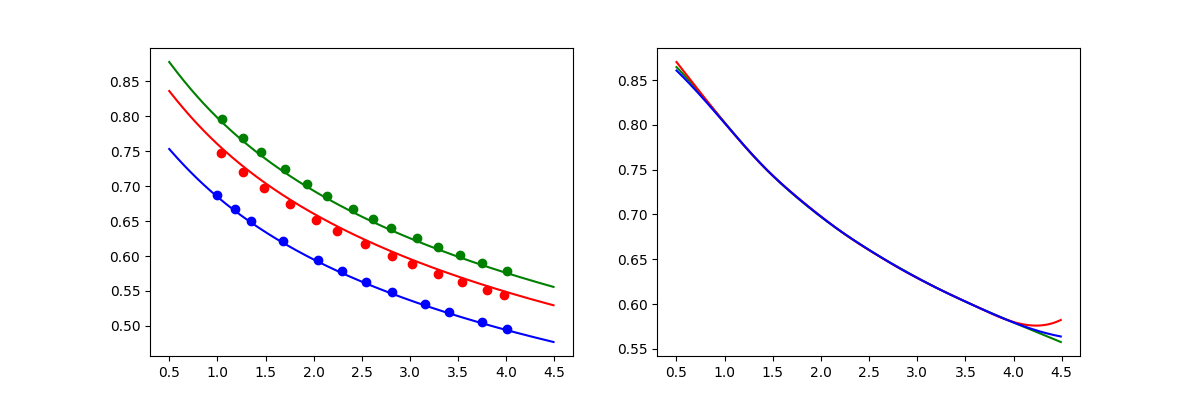

In [26]:
# plot the data to check if the fits is decent
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].scatter(smm_fig_4_blue[:, 0], smm_fig_4_blue[:, 1], color = 'blue')
ax[0].scatter(smm_fig_4_green[:, 0], smm_fig_4_green[:, 1], color = 'green')
ax[0].scatter(smm_fig_4_red[:, 0], smm_fig_4_red[:, 1], color = 'red')

# get interpolation to see if I can do something smart-ish
spline_green = ius(smm_fig_4_blue[:, 0], smm_fig_4_blue[:, 1])
spline_blue  = ius(smm_fig_4_green[:, 0], smm_fig_4_green[:, 1])
# sort the red, I am an idiot
_, sorting_inds_red = np.unique(smm_fig_4_red[:, 0], return_index = True)
smm_fig_4_red_x = smm_fig_4_red[:, 0][sorting_inds_red]
smm_fig_4_red_y = smm_fig_4_red[:, 1][sorting_inds_red]
spline_red = ius(smm_fig_4_red_x, smm_fig_4_red_y)

x, m1_f4, m2_f4, m3_f4 = residual_check_4_pars(out_fig_4.params, **{'plot' : True, 'data_1': smm_fig_4_green, 'data_2': smm_fig_4_red, 'data_3': smm_fig_4_blue})

ax[0].plot(x, m1_f4, color = 'green')
ax[0].plot(x, m2_f4, color = 'red')
ax[0].plot(x, m3_f4, color = 'blue')

ax[1].plot(x, spline_green(x) * np.median(spline_blue(x)/spline_green(x)), color = 'green')
ax[1].plot(x, spline_red(x) * np.median(spline_blue(x)/spline_red(x)), color = 'red')
ax[1].plot(x, spline_blue(x), color = 'blue')

# fit the new data points - hopefully this will allow me to the a new value representing the resolution
smm_fig_4_green_new_pts = spline_green(x) * np.median(spline_blue(x)/spline_green(x))
smm_fig_4_red_new_pts = spline_red(x) * np.median(spline_blue(x)/spline_red(x))
smm_fig_4_blue_new_pts = spline_blue(x)

In [27]:
# Not great, but as far as I can tell this is the best we can get out of the data. No idea what I am doing wrong tbh...
# Keep in mind that with what I have there is degeneracy between d_1 and d_3!

# Still, this whole thing makes little sense, there does not seem to be a dependence on the resolution whatsoever in everything I've done till now
#  Places where it might enter:
#  - I missed a convolution with the instrumental PSF at the beginning
#  - The mystery formula is just y = x / 2sqrt(ln2) -> see last email with MM, there is at least a log() somewhere involved - most likely in the x part of the separable expression
#  - The resolution is given by 2*pix_size
#  - ??? -> we are going with this for now, resolution does not enter anywhere in the simulations

In [58]:
#%%script echo Skipped
# Now, the problem: in the previous case, I have that all my values are different from what MM finds, so I have no reason to suspect differences for this
# the smart thing to do, which is what we now try, is to re-do what they did, and see what comes out

mc_fix_err_params = Parameters()
mc_fix_err_params.add('ampl',  value = 1)
mc_fix_err_params.add('shift', value = 0.8)
mc_fix_err_params.add('tilt',  value = 0)

res_all_fix_err = {}

# change dispersion
for i in [1., 1.5, 2.]:
    res_all_fix_err[i] = utils_fit.loop_change_dispersion(p_sp_1, p_sp_2, utils_fit.fit_many_times, 1. * utils.kms, 10. * utils.kms, 0.5 * utils.kms, i * utils.kms, i * utils.kms,
                                                          rep = 10000, correct_for_err=False, correct_for_smooth=True, corrfunc= lambda x: utils_fit.chi2_corr_func(x, params = fix_x2_outvals))

100%|██████████| 18/18 [24:20<00:00, 81.15s/it]


In [29]:
%%script echo Skipped
# save data
with open("./data/fix_err_res.npy", 'wb') as f:
    np.save(f, {"smooth_1" : n_smooth_pix_1, "smooth_2" : n_smooth_pix_2})
    np.save(f, res_all_fix_err)


Skipped


In [30]:
# results from the cell above, but the data points from mm seem mostly fine
with open("./data/fix_err_res.npy", 'rb') as f:
    _ = np.load(f, allow_pickle = True)
    res_all_fix_err = np.load(f, allow_pickle = True).item()

In [31]:
# unified the code so that it's easier to parse
# res_all_fix_err[key]:
#    0 -> values
#       0 -> values for a convolution pixel [0 ... len()-1]
#          0 -> val of shift
#          1 -> val of err
#          2 -> val of x^2
#       ...
#    1 -> pixels you use to spline

(0.8, 6.0)

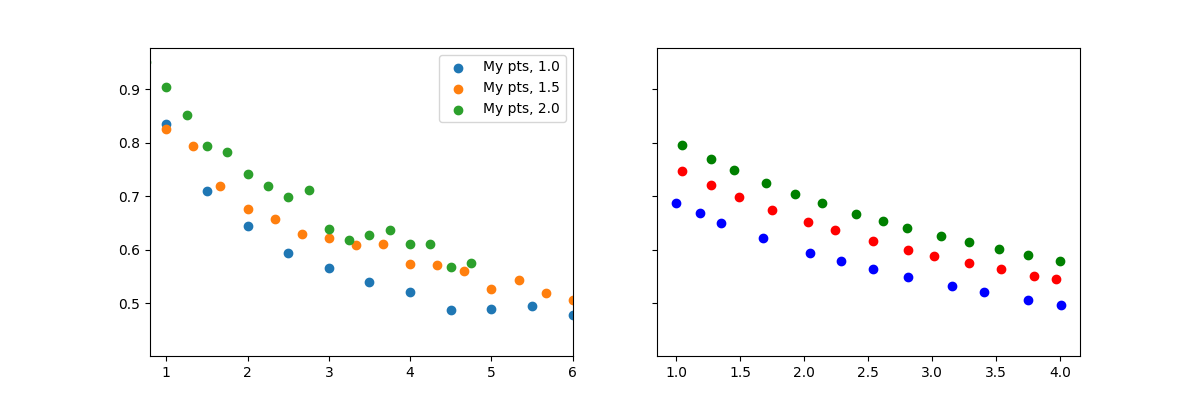

In [57]:
# plot the results, and check against MM points
# this dict is only useful for fitting (see next cell, numbers do not work, as always...)
dict_4_params_fit = {}

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharey=True)
for key in res_all_fix_err.keys():
    errs_from_hist = np.array([norm.fit(i[0])[1] for i in res_all_fix_err[key][0]])
    ax[0].scatter(res_all_fix_err[key][1], np.mean(np.array(res_all_fix_err[key][0])[:, 1], axis = 1)/errs_from_hist, label = "My pts, " + str(key))
    dict_4_params_fit[key] = [np.mean(np.array(res_all_fix_err[key][0])[:, 1], axis = 1)/errs_from_hist, res_all_fix_err[key][1]]

ax[1].scatter(smm_fig_4_blue[:, 0], smm_fig_4_blue[:, 1], color = 'blue')
ax[1].scatter(smm_fig_4_green[:, 0], smm_fig_4_green[:, 1], color = 'green')
ax[1].scatter(smm_fig_4_red[:, 0], smm_fig_4_red[:, 1], color = 'red')

ax[0].legend()
ax[0].set_xlim(0.8, 6.)

Chi2 for this fit: 0.13


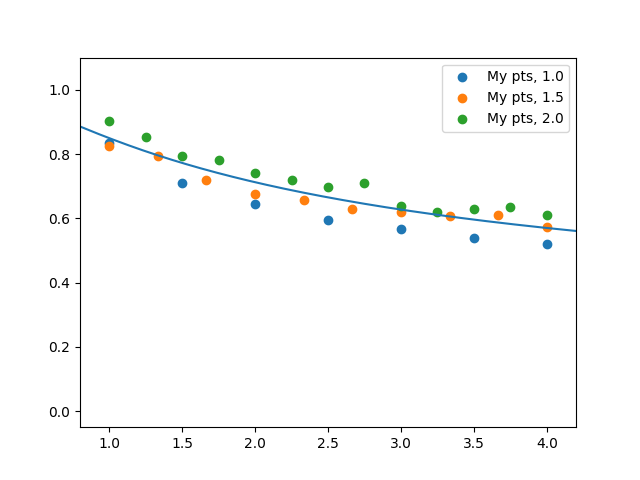

In [33]:
# I am not really seeing the points given my MM
# fitting with a function similar to the one used for the previous point I get
# fit my datapoints for figure 3, not sure why they are different
fig, ax = plt.subplots(1, 1)

# we try to fit all points at the same time - TODO: find out who is making a stupid mistake
params_fig_4_refit = Parameters()
params_fig_4_refit.add('a', value = 0)
params_fig_4_refit.add('b', value = 0)
params_fig_4_refit.add('c', value = 0)
params_fig_4_refit.add('d', value = 0)


def residual_fix_err(pars, data = None, plot = False, p_x = np.arange(0.5, 8.5, 0.01)):
    # data in this case is a dictionary that contains all the data, loaded from previous cell
    # computes the model wrt the data
    def compute_model(pars, x):
        vals = pars.valuesdict()
        a = vals['a']
        b = vals['b']
        c = vals['c']
        d = vals['d']
        return d + np.exp(a * np.log(x)**2 + b * np.log(x) + c)

    if plot:
        xval = p_x
        out = compute_model(pars, xval)
    else:
        out = np.array([])
        for key in data.keys():
            xval = data[key][1]
            yval = data[key][0]
            dyval = np.ones(yval.shape) * 0.1

            # cut the first part of the data (they flat, good luck with fitting those with anything)
            #  this depends on the convoluting window, ergo we need to a) find a smart way to perform this automagically or,
            #  b) take the easy route, make a dictionary, and call it a day
            # Guess what we do!
            xval  =  xval
            yval  =  yval
            dyval = dyval

            out = np.concatenate((out, (compute_model(pars, xval) - yval)/dyval))

    return out

# Could improve on this
fix_err_out     = minimize(residual_fix_err, params_fig_4_refit, kws={'data' : dict_4_params_fit, 'plot' : False})
fix_err_outvals = fix_err_out.params.valuesdict()
print("Chi2 for this fit: {:.2f}".format(fix_err_out.redchi))

# get the model line
p_x = np.arange(0.5, 8.5, 0.01)
p_model_lines = residual_fix_err(fix_err_out.params, data = dict_4_params_fit, plot = True, p_x = p_x)

# get the x points of the lines
ax.plot(p_x, p_model_lines)

# plot both together
for key in dict_4_params_fit.keys():
    ax.scatter(dict_4_params_fit[key][1], dict_4_params_fit[key][0], label = "My pts, " + str(key))

# uncomment to show MM values or line fit
# ax.plot(x_plot, np.exp(-0.16 * np.log(x_plot)**2 - 0.62 * np.log(x_plot) - 0.76), label = "MM params")

ax.set_ylim(-0.05, 1.1)
ax.set_xlim(0.8, 4.2)
ax.legend()

In [34]:
# Same as before, but with error correction
mc_fix_x2_err_params = Parameters()
mc_fix_x2_err_params.add('ampl',  value = 1)
mc_fix_x2_err_params.add('shift', value = 0.8)
mc_fix_x2_err_params.add('tilt',  value = 0)

# collect all estimates of value and error
mc_fix_x2_err_val = []
mc_fix_x2_err_err = []
mc_fix_x2_err_xsq = []

xi_sigma, xi_fwhm = utils.compute_corrections(outvals_fig_4, n_smooth_pix_2, y_corr_err)
#xi_sigma = utils_fit.chi2_corr_func(2, params = fix_err_outvals)
#xi_fwhm = 1

# NB: we still use MM function to correct for the error
for i in tqdm(range(mc_n_rep)):
    val, err, chi = utils_fit.fit_for_shift(p_sp_1, p_sp_2, shift=0.3 * utils.kms, n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2,
                                            correct_for_smooth=True, correct_for_err = True, xi_sigma = xi_sigma, xi_fwhm = xi_fwhm, corrfunc= lambda x: utils_fit.chi2_corr_func(x, params = fix_x2_outvals))
    mc_fix_x2_err_val.append(val)
    mc_fix_x2_err_err.append(err)
    mc_fix_x2_err_xsq.append(chi)

100%|██████████| 5000/5000 [00:32<00:00, 155.11it/s]


Average chi square for this round: 0.993


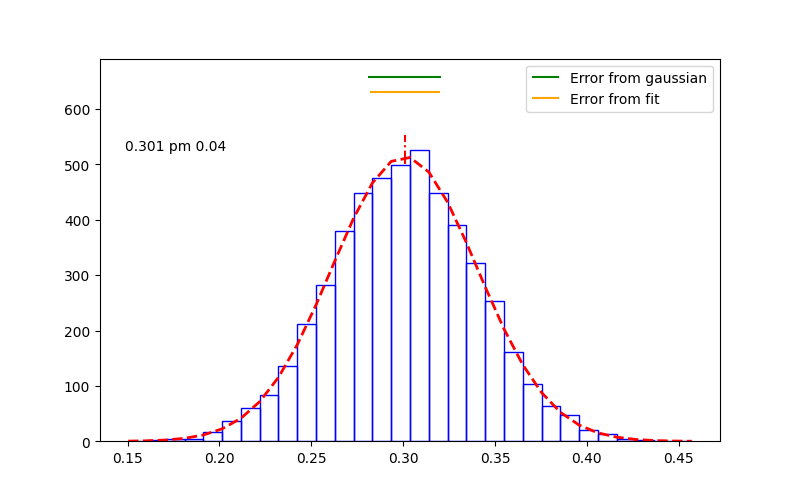

In [35]:
# and plot!
utils.plot_simulation_results(mc_fix_x2_err_val, mc_fix_x2_err_err, mc_fix_x2_err_xsq);

In [36]:
#%%script echo Skipped
# values saved for the fitting functions
# create a timestamp automatically
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d')

with open('Params_{}.npy'.format(timestamp), 'wb') as f:
    np.save(f, fix_x2_outvals)
    np.save(f, outvals_fig_4)

In [37]:
# recompute the value for xi_sigma and xi_fwhm: they depend on the number of pixels you use to smooth
#  to check: what if I used a different number of pixels to smooth the two spectra? I guess I should take the spectrum with the highest SNR/resolution as reference?
#  testing this could help answer this question...

# to future self: this assumes that the one with more information (higher SNR, resolution, whatever you want) is the #2
# see at the beginning of the notebook for the values of y and n_smooth
# Few important points:  
#  - this is correct for R = 100000, and a dispersion of 1.5 km/s per pixel. If different, you recompute y! (maybe? )
#  - again, we assume that y_corr_err comes from the spectrum with more information, i.e. with the one that has higher whatever you want.
#      Adjust resolution and everything else based on that!
chosen_timestamp = "2023-05-09"

with open('Params_{}.npy'.format(chosen_timestamp), 'rb') as f:
    saved_fix_x2_params = np.load(f, allow_pickle = True).item()
    saved_fix_err_params = np.load(f, allow_pickle = True).item()

xi_sigma, xi_fwhm = utils.compute_corrections(saved_fix_err_params, n_smooth_pix_2, y_corr_err)
# we use the correction given in the paper, as I am not sure how it was obtained!

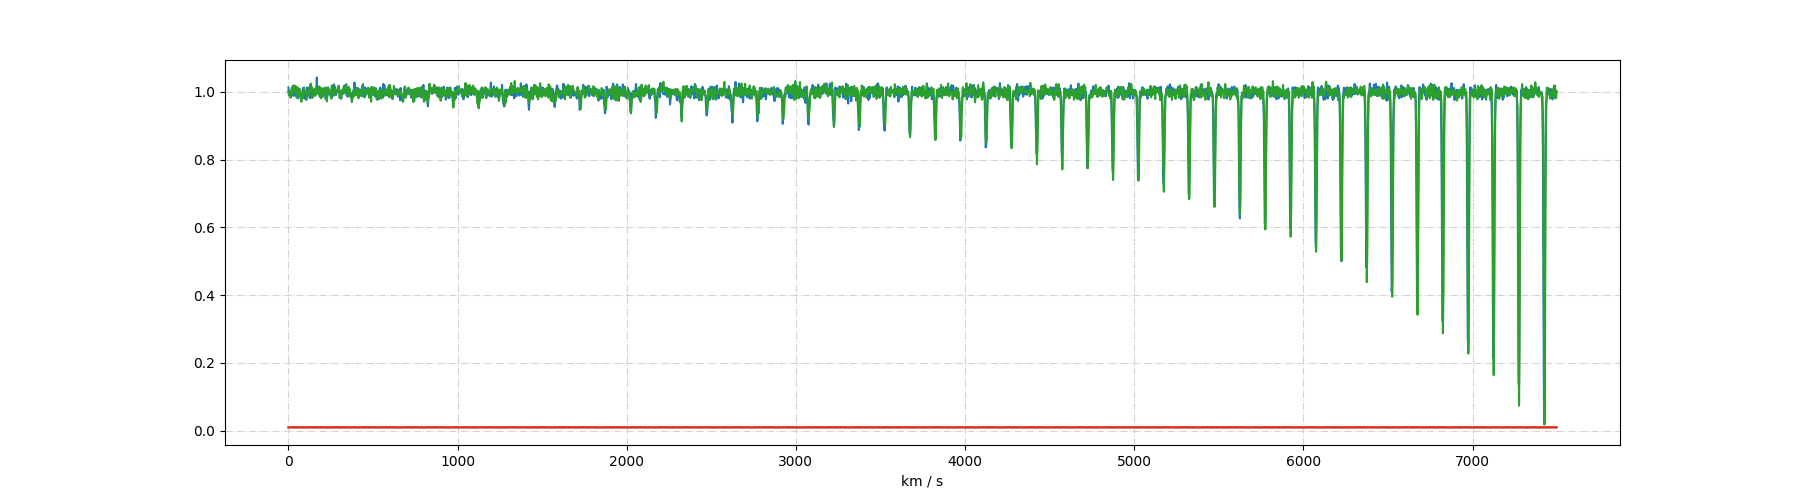

In [38]:
# in the following I there something funny happening with the error arrays and the code itself, and I can't quite understand what that is.
#  Looking at core.py seemed to give some hint of issues in the normalizion and de-normalization of the error, but until I see the original code
#  (assuming I ever see it) I can't really tell. Meh! 
p_sp_liske = {
    'snr' : 100,
    'R' : 1e5,                     # resolution should be roughly twice the dispersion, otherwise boh! From fits it appears to be 60k.
                                   #  in any case, it has no influence in the results, aside from the xhi square/error corrections
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms,
    'noise_amp' : 1e-2             # If I want the spectrum to have SNR equal to 100, this is the noise amplitude I need for the continuum
}

# these will become the spectra
synth_spec_list_1 = []
synth_spec_list_2 = []

for i in np.logspace(-0.75, 1):
    params_i_1, params_i_2 = dc(p_sp_liske), dc(p_sp_liske)
    
    # change amplitude for a line
    params_i_1['amp'] = i/10
    params_i_2['amp'] = i/10
    
    # also shift the second spectrum
    params_i_2['pos'] += 1. * utils.kms

    spec_i_1 = gspec.mock_spec(**params_i_1)
    spec_i_1.generate()
    spec_i_2 = gspec.mock_spec(**params_i_2)
    spec_i_2.generate()
    
    synth_spec_list_1.append(spec_i_1)
    synth_spec_list_2.append(spec_i_2)
    
merged_spec_1 = spec_man.merge_spec(*synth_spec_list_1)
merged_spec_2 = spec_man.merge_spec(*synth_spec_list_2)

merged_spec_1.x += merged_spec_1.x #+ 1. * utils.kms
merged_spec_2.x += merged_spec_2.x #+ 1. * utils.kms

merged_spec_1.n_orig_pix = p_sp_liske['npix']

utils.plot_multi_spec(merged_spec_1, merged_spec_2, figsize = (18, 5))

# smooth the spectra, and spline the second one
merged_spec_1.smooth(n_smooth_pix_1)
merged_spec_2.spline(n_smooth_pix_2)

In [39]:
liske_rep = 250
N = 4 # see paper

tracker_pts_plot, e_tracker_pts_plot, e_plot = [], [], []

for (i, j) in tqdm(zip(utils.split_chunk_independently(merged_spec_1, n_pix_chunk = merged_spec_1.n_orig_pix), utils.split_chunk_independently(merged_spec_2, n_pix_chunk = merged_spec_1.n_orig_pix))):
    # we create mock spectra out of this to have a more uniform interface
    sp_1 = gspec.mock_spec(wave = i[0] * utils.kms, flux = i[1] * utils.adm, err = i[2] * utils.adm)
    sp_2 = gspec.mock_spec(wave = j[0] * utils.kms, flux = j[1] * utils.adm, err = j[2] * utils.adm)

    # smooth this thing as well
    sp_1.smooth(n_smooth_pix_1)
    sp_2.spline(n_smooth_pix_2)

    # apply correction to the errors
    sp_1.corr_err(utils_fit.chi2_corr_func(2, params = saved_fix_x2_params))
    sp_2.corr_err(utils_fit.chi2_corr_func(2, params = saved_fix_x2_params))
    
    current_tracker_point, e_current_tracker_point = lsk.generate_tracker_pts(sp_1, sp_2, liske_rep, n_smooth_pix_1, n_smooth_pix_2)

    tracker_pts_plot.append(current_tracker_point)
    e_tracker_pts_plot.append(N * e_current_tracker_point)
    
    e_plot.append(lsk.compute_liske_uncertainty(sp_1, sp_2, which = 'spline', xi_sigma=xi_sigma, xi_fwhm=xi_fwhm))

50it [00:27,  1.81it/s]


(-0.05, 1.15)

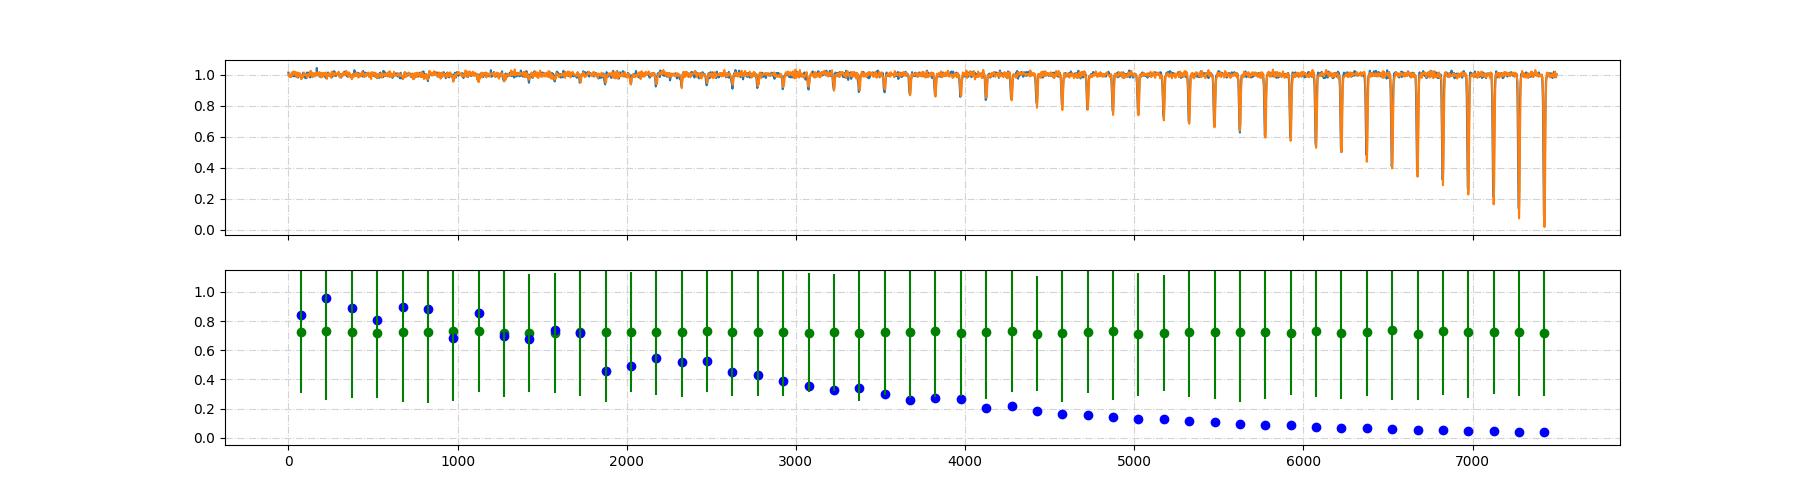

In [40]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (18, 5))

ax[0].plot(merged_spec_1.x, merged_spec_1.y)
ax[0].plot(merged_spec_2.x, merged_spec_2.y)

ax[1].errorbar(merged_spec_1.x[::50] + (merged_spec_1.x[::50][1] - merged_spec_1.x[::50][0])/2, tracker_pts_plot, yerr = e_tracker_pts_plot, ls = 'none', color = 'green')
ax[1].scatter(merged_spec_1.x[::50] + (merged_spec_1.x[::50][1] - merged_spec_1.x[::50][0])/2, tracker_pts_plot, color = 'green')

ax[1].scatter(merged_spec_1.x[::50] + (merged_spec_1.x[::50][1] - merged_spec_1.x[::50][0])/2, e_plot, color = 'blue')

ax[0].grid(ls = '-.', color = 'lightgrey')
ax[1].grid(ls = '-.', color = 'lightgrey')

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

ax[1].set_ylim(-0.05, 1.15)

In [41]:
# these is a clear difference wrt to what they show in their paper
# the function that computes the Liske uncertainty is however the same (or, well, seems to give the same exact results)

In [42]:
# test the same using two lines, (partially) blended together
p_sp_blended_1 = {
    'snr' : 100,
    'R' : 1e5,                     # resolution should be roughly twice the dispersion, otherwise boh!
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : [0.0, 0.0] * utils.kms,
    'noise_amp' : 0.01             # If I want the spectrum to have SNR equal to 100, this is the noise amplitude I need for the continuum
                                   # should not need to set this, but it's safer to keep things explicit, so here it stays
}

p_sp_blended_2 = {
    'snr' : 100,
    'R' : 1e5,
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : [0.0, 0.0] * utils.kms,
    'noise_amp' : 0.01
}

In [43]:
# temporary reduce mc_n_rep
mc_n_rep = 500

In [44]:
# now, try to implement the generation of two gaussians
# in principle is easy, I just have to generate two separate spectra, and multiply them
blended_chunk_res = {}

for j in tqdm(range(11)):
    mc_blended_val = []
    mc_blended_err = []
    mc_blended_xsq = []
    
    for i in range(mc_n_rep):
        pos = [-j, j] * utils.kms
        p_sp_blended_1['pos'] = pos
        p_sp_blended_2['pos'] = pos
        
        mc_blended_val_i, mc_blended_err_i, mc_blended_xsq_i = utils_fit.fit_for_shift(p_sp_blended_1, p_sp_blended_2, shift=0.3 * utils.kms, n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2,
                                            correct_for_smooth=True, correct_for_err = True, xi_sigma = xi_sigma, xi_fwhm = xi_fwhm, corrfunc= lambda x: utils_fit.chi2_corr_func(x, params = saved_fix_x2_params))
        mc_blended_val.append(mc_blended_val_i)
        mc_blended_err.append(mc_blended_err_i)
        mc_blended_xsq.append(mc_blended_xsq_i)
        
    blended_chunk_res[j] = [mc_blended_val, mc_blended_err, mc_blended_xsq]

100%|██████████| 11/11 [00:39<00:00,  3.57s/it]


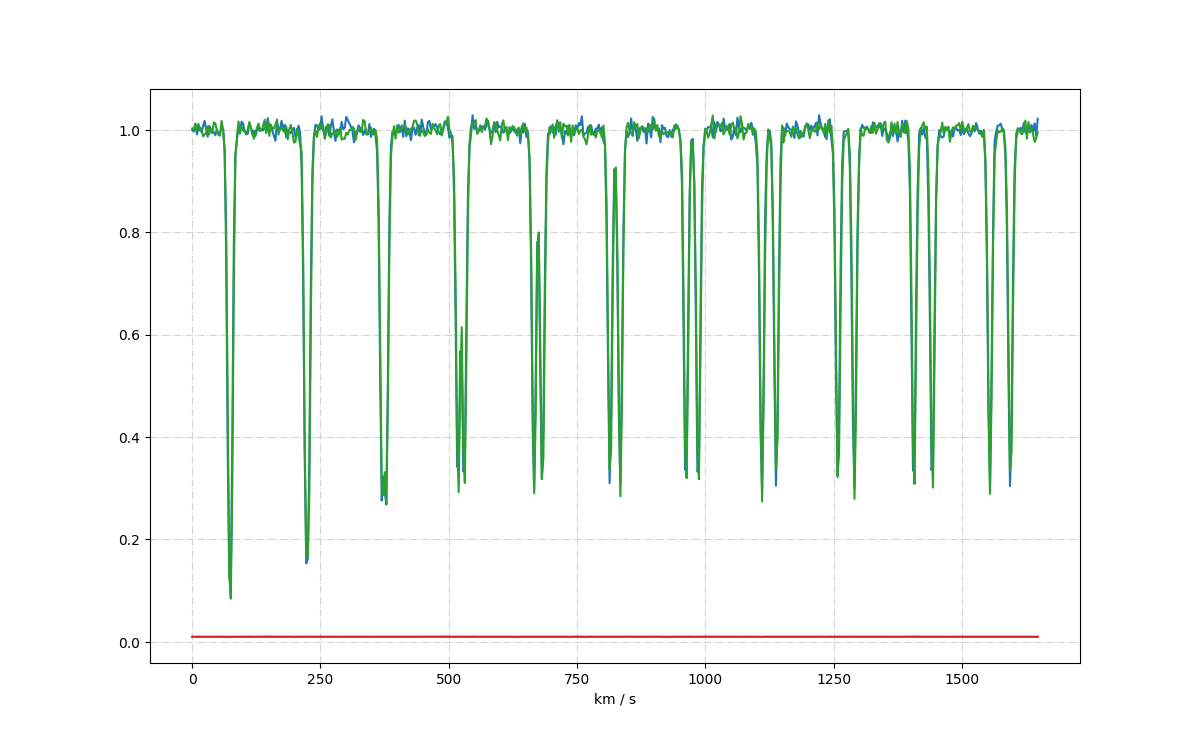

In [45]:
# create merged spec, just for plotting (and maybe for the Liske version of the cell just above)
# generate spectra

# these will become the spectra
blended_spec_list_1 = []
blended_spec_list_2 = []

for i in range(0, 11):
    pos = [-i, i] * utils.kms
    p_sp_blended_1['pos'] = pos
    p_sp_blended_2['pos'] = pos
    params_i_1, params_i_2 = dc(p_sp_blended_1), dc(p_sp_blended_2)
    
    # also shift the second spectrum
    params_i_2['pos'] += 0.3 * utils.kms

    spec_i_1 = gspec.mock_spec(**params_i_1)
    spec_i_1.generate()
    spec_i_2 = gspec.mock_spec(**params_i_2)
    spec_i_2.generate()
    
    blended_spec_list_1.append(spec_i_1)
    blended_spec_list_2.append(spec_i_2)
    
blended_merged_spec_1 = spec_man.merge_spec(*blended_spec_list_1)
blended_merged_spec_2 = spec_man.merge_spec(*blended_spec_list_2)

blended_merged_spec_1.x += blended_merged_spec_1.x + 0.3 * utils.kms
blended_merged_spec_2.x += blended_merged_spec_2.x + 0.3 * utils.kms

blended_merged_spec_1.n_orig_pix = p_sp_blended_1['npix']

utils.plot_multi_spec(blended_merged_spec_1, blended_merged_spec_2)

In [46]:
blended_e_liske = []

for (i, j) in tqdm(zip(utils.split_chunk_independently(blended_merged_spec_1, n_pix_chunk = blended_merged_spec_1.n_orig_pix), utils.split_chunk_independently(blended_merged_spec_2, n_pix_chunk = blended_merged_spec_1.n_orig_pix))):
    # repeat liske_rep times
    # create temporary spectra to compute the shift
    merged_features_sp_1 = gspec.mock_spec(wave = i[0] * utils.kms, flux = i[1] * utils.adm, err = i[2] * utils.adm)
    merged_features_sp_2 = gspec.mock_spec(wave = j[0] * utils.kms, flux = j[1] * utils.adm, err = j[2] * utils.adm)

    # smooth and spline
    merged_features_sp_1.smooth(n_smooth_pix_1)
    merged_features_sp_2.spline(n_smooth_pix_2)

    # correct the errors
    merged_features_sp_1.corr_err(utils_fit.chi2_corr_func(n_smooth_pix_1, params = saved_fix_x2_params))
    merged_features_sp_2.corr_err(utils_fit.chi2_corr_func(n_smooth_pix_2, params = saved_fix_x2_params))

    # compute the uncertainty
    blended_e_liske.append(lsk.compute_liske_uncertainty(merged_features_sp_1, merged_features_sp_2, which = 'spline', xi_sigma=xi_sigma, xi_fwhm=xi_fwhm))
    
blended_e_liske = np.array(blended_e_liske)

11it [00:00, 128.40it/s]


In [47]:
# parse the results of the fitting procedure
blended_shift = []
blended_err   = []
for i in range(11):
    _blended_shift, _blended_err, _ = np.mean(blended_chunk_res[i], axis = 1) # the third element is the chi^2
    blended_shift.append(_blended_shift)
    blended_err.append(_blended_err)
    
blended_shift = np.array(blended_shift)
blended_err   = np.array(blended_err)

(0.0, 1.1)

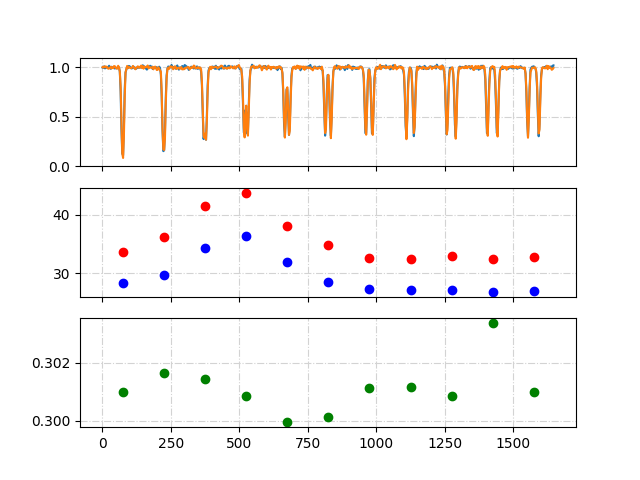

In [48]:
fig, ax = plt.subplots(3, 1, sharex = True)

ax[0].plot(blended_merged_spec_1.x, blended_merged_spec_1.y)
ax[0].plot(blended_merged_spec_2.x, blended_merged_spec_2.y)

ax[1].scatter(blended_merged_spec_1.x[::50] + (blended_merged_spec_1.x[::50][1] - blended_merged_spec_1.x[::50][0])/2, blended_err * 1000, color = 'blue')
ax[1].scatter(blended_merged_spec_1.x[::50] + (blended_merged_spec_1.x[::50][1] - blended_merged_spec_1.x[::50][0])/2, blended_e_liske * 1000, color = 'red')
ax[2].scatter(blended_merged_spec_1.x[::50] + (blended_merged_spec_1.x[::50][1] - blended_merged_spec_1.x[::50][0])/2, blended_shift, color = 'green')

ax[0].grid(ls = '-.', color = 'lightgrey')
ax[1].grid(ls = '-.', color = 'lightgrey')
ax[2].grid(ls = '-.', color = 'lightgrey')

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[2].set_axisbelow(True)

ax[0].set_ylim(0, 1.1)

In [49]:
# in addition to this, we also check if the Liske et al uncertainty goes as stated in the paper

# we keep once again the shift as equal to 0.3
p_sp_change_snr_1 = {
    'snr' : 100,
    'R' : 1e5,                     # resolution should be roughly twice the dispersion, otherwise boh!
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms
}

p_sp_change_snr_2 = {
    'snr' : 100,
    'R' : 1e5,
    'sigma' : 2.0 * utils.kms,
    'dispersion' : 1.5 * utils.kms,
    'npix' : 50,
    'amp' : 0.7,
    'pos' : 0.0 * utils.kms
}

change_snr_res = {}

for i in tqdm(np.logspace(0.301, 3, 15)):
    _p_sp_change_snr_1, _p_sp_change_snr_2 = dc(p_sp_change_snr_1), dc(p_sp_change_snr_2)

    # change params for each iteration
    _p_sp_change_snr_1['snr'] = i
    _p_sp_change_snr_2['snr'] = i
    #_p_sp_change_snr_2['pos'] += 0.3 * utils.kms -> you do this below
    
    # we collect the results in here,
    mc_change_snr_val = []
    mc_change_snr_err = []
    mc_change_snr_xsq = []
    
    mc_change_snr_liske = []

    for (n, rep) in enumerate(range(mc_n_rep)):
        s_change_snr_1, s_change_snr_2 = spec_man.gen_spec_pair(_p_sp_change_snr_1, _p_sp_change_snr_2, shift=0.3 * utils.kms, n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2)

        # fix the error
        s_change_snr_1.corr_err(utils_fit.chi2_corr_func(n_smooth_pix_1, params = saved_fix_x2_params))
        s_change_snr_2.corr_err(utils_fit.chi2_corr_func(n_smooth_pix_2, params = saved_fix_x2_params))

        # fit for the shift, and compute liske uncertainty
        mc_change_snr_val_i, mc_change_snr_err_i, mc_change_snr_xsq_i = utils_fit.fit_for_shift(s_change_snr_1, s_change_snr_2, n_smooth_pix_1=n_smooth_pix_1, n_smooth_pix_2=n_smooth_pix_2,
                                            correct_for_smooth=True, correct_for_err = True, xi_sigma = xi_sigma, xi_fwhm = xi_fwhm, corrfunc= lambda x: utils_fit.chi2_corr_func(x, params = saved_fix_x2_params))

        mc_change_snr_val.append(mc_change_snr_val_i)
        mc_change_snr_err.append(mc_change_snr_err_i)
        mc_change_snr_xsq.append(mc_change_snr_xsq_i)
        
        mc_change_snr_liske.append(lsk.compute_liske_uncertainty(s_change_snr_1, s_change_snr_2, which = 'spline', xi_sigma=xi_sigma, xi_fwhm=xi_fwhm))
            
    change_snr_res[i] = [mc_change_snr_val, mc_change_snr_err, mc_change_snr_xsq, mc_change_snr_liske]

100%|██████████| 15/15 [01:02<00:00,  4.14s/it]


In [50]:
# parse the results of the fitting procedure
change_snr_shift = []
change_snr_err   = []
change_snr_liske = []

for i in np.logspace(0.301, 3, 15):
    _change_snr_shift, _change_snr_err, _, _change_snr_liske = np.mean(change_snr_res[i], axis = 1) # ignore the chi square, seems to be around 1
    change_snr_shift.append(_change_snr_shift)
    change_snr_err.append(_change_snr_err)
    change_snr_liske.append(_change_snr_liske)
    
change_snr_shift = np.array(change_snr_shift)
change_snr_err   = np.array(change_snr_err)
change_snr_liske = np.array(change_snr_liske)

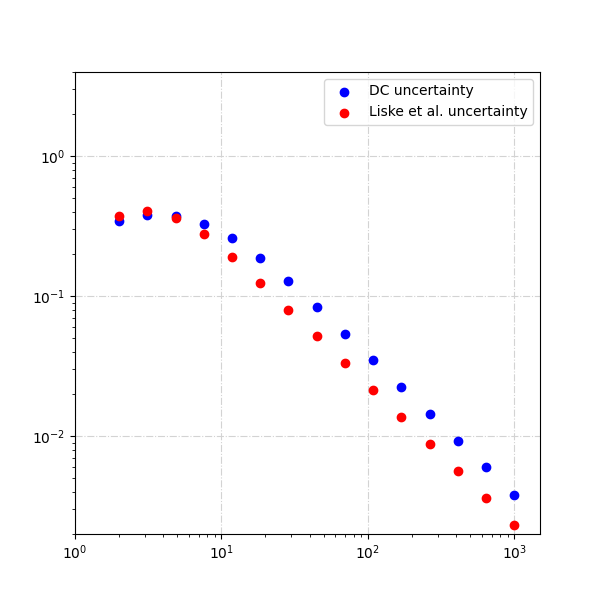

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

ax.scatter(np.logspace(0.301, 3, 15), change_snr_err, color = 'blue', label = 'DC uncertainty')
ax.scatter(np.logspace(0.301, 3, 15), change_snr_liske, color = 'red', label = 'Liske et al. uncertainty')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1, 1.5e3)
ax.set_ylim(2e-3, 4)

ax.grid(ls = '-.', color = 'lightgrey')
ax.set_axisbelow(True)

ax.legend()